# Generating trading signals with Linear Regression

This notebook illustrates the following steps:
1. **Cross-validation in the time-series context** poses the additional challenge that train and validation sets need to respect the temporal order of the data so that we do not inadvertently train the model on data 'from the future' to predict the past and introduce lookahead bias. Scikit-learn's built-in [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) aims to accomplish this but does not work for this case where we have multiple time series, one for each ticker. We could solve this by manually subsetting the data for the appropriate train and validation periods. Alternatively, we can create a custom time-series splitter compatible with the scikit-learn Kfold interface (see resources). Here is an [example](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/utils.py) that illustrates how to do so for this case. This allows us to specify fixed `train_length` and `test_length` parameters, as well as a `lookahead` value that defines the forecast horizon and ensures an appropriate gap between the training and validation set.
2. To establish a **baseline**, train a [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) using five years of training data to predict rolling windows of three months of returns for the years 2013-2016. Evaluate the results by computing the information coefficient (IC) as the Spearman rank correlation between the predictions and the actual returns, averaged per day.
3. Next, we'll use **regularized regression** models that include a penalty term to shrink the coefficients and limit the risk of overfitting. Cross-validate a range of `alpha` penalty values for [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) using the same training and validation periods as for the linear regression baseline and compare their performance.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

## Settings

In [3]:
sns.set_style('whitegrid')

In [4]:
np.random.seed(42)

In [6]:
idx = pd.IndexSlice

In [7]:
YEAR = 252 # days
MONTH = 21 # days

In [8]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

## Get Data

In [5]:
data = (pd.read_hdf('stock_prices.h5', 'model_data')
        .sort_index())

In [11]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1383053 entries, (Timestamp('2006-01-03 00:00:00'), 'A') to (Timestamp('2016-12-29 00:00:00'), 'ZTS')
Data columns (total 52 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol_rank  1383053 non-null  float64
 1   ret_01           1381655 non-null  float64
 2   ret_03           1378992 non-null  float64
 3   ret_05           1376426 non-null  float64
 4   ret_10           1370266 non-null  float64
 5   ret_21           1357487 non-null  float64
 6   ret_42           1335340 non-null  float64
 7   ret_63           1314565 non-null  float64
 8   ret_126          1257666 non-null  float64
 9   ret_252          1155277 non-null  float64
 10  ret_fwd          1383053 non-null  float64
 11  BB_UP            1358598 non-null  float64
 12  BB_LOW           1358598 non-null  float64
 13  BB_SQUEEZE       1358598 non-null  float64
 14  HT               1314565 non-null  float64

In [12]:
target = 'ret_fwd'
features = data.columns.drop(target)

In [13]:
categoricals = ['month', 'weekday']

## Custom Time Series Cross-Validation

In [14]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

## Model Selection: Lookback, lookahead and roll-forward periods

In [15]:
train_length = 5 * YEAR
test_length = 3 * MONTH

In [16]:
lookahead = 1

In [17]:
n_splits = 16

In [18]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_length,
                          lookahead=lookahead,
                          train_period_length=train_length)

In [19]:
for n_split, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    
    train_days = train.groupby(level="ticker").size().value_counts().index[0]
    train_start, train_end = train_dates.min().date(), train_dates.max().date()
    
    test_days = test.groupby(level="ticker").size().value_counts().index[0]
    test_start, test_end = test_dates.min().date(), test_dates.max().date()
                                                  
    print(f'Split: {n_split:02} | # Train: {train_start} - {train_end} ({train_days:5,.0f} days) | '
          f'Test: {test_start} - {test_end} ({test_days} days)')

Split: 00 | # Train: 2011-11-07 - 2016-09-29 (1,232 days) | Test: 2016-09-30 - 2016-12-29 (63 days)
Split: 01 | # Train: 2011-08-09 - 2016-06-30 (1,232 days) | Test: 2016-07-01 - 2016-09-29 (63 days)
Split: 02 | # Train: 2011-05-10 - 2016-04-01 (1,232 days) | Test: 2016-04-04 - 2016-06-30 (63 days)
Split: 03 | # Train: 2011-02-08 - 2015-12-30 (1,232 days) | Test: 2015-12-31 - 2016-04-01 (63 days)
Split: 04 | # Train: 2010-11-08 - 2015-09-30 (1,232 days) | Test: 2015-10-01 - 2015-12-30 (63 days)
Split: 05 | # Train: 2010-08-10 - 2015-07-01 (1,232 days) | Test: 2015-07-02 - 2015-09-30 (63 days)
Split: 06 | # Train: 2010-05-11 - 2015-04-01 (1,232 days) | Test: 2015-04-02 - 2015-07-01 (63 days)
Split: 07 | # Train: 2010-02-09 - 2014-12-30 (1,232 days) | Test: 2014-12-31 - 2015-04-01 (63 days)
Split: 08 | # Train: 2009-11-06 - 2014-09-30 (1,232 days) | Test: 2014-10-01 - 2014-12-30 (63 days)
Split: 09 | # Train: 2009-08-10 - 2014-07-02 (1,233 days) | Test: 2014-07-03 - 2014-09-30 (62 days)


## Baseline: Linear Regression

In [20]:
df = (pd.get_dummies(data, columns=categoricals, drop_first=True)
      .dropna()
      .sort_index())

X = df.drop(target, axis=1)
y = df[target]

### Run cross-validation

In [21]:
lr = LinearRegression()

In [22]:
%%time
lr_preds = []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    lr_preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
lr_preds = pd.concat(lr_preds)

CPU times: user 11min 51s, sys: 1min 40s, total: 13min 32s
Wall time: 9min 52s


In [23]:
lr_preds.to_hdf('predictions.h5', 'linear_regression')

### Evaluate Predictions using the Information Coefficient

In [24]:
lr_ic, p = spearmanr(lr_preds.y_true, lr_preds.y_pred)
f'{lr_ic:.4f} ({p:.2%})'

'0.0246 (0.00%)'

In [25]:
daily_ic_lr = lr_preds.groupby(level='date').apply(lambda x: spearmanr(x.y_true, x.y_pred)[0])

In [26]:
f'Daily IC - Mean: {daily_ic_lr.mean():.4f} | CV: {daily_ic_lr.std()/daily_ic_lr.mean():.2f}'

'Daily IC - Mean: 0.0080 | CV: 16.15'

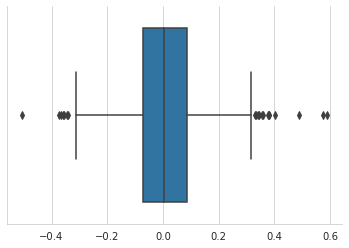

In [27]:
sns.boxplot(daily_ic_lr)
sns.despine();

## Regularized Linear Regression

### Ridge Regression

In [29]:
ridge_alphas = np.logspace(-5, 15, 21)[::2]

In [30]:
ridge_alphas

array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09,
       1.e+11, 1.e+13, 1.e+15])

In [31]:
%%time
ridge_preds = []
scaler = MinMaxScaler()
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'{i}', end=' ', flush=True)
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_train = scaler.fit_transform(X_train)
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_test = scaler.transform(X_test)
    cv_predictions = []
    for alpha in ridge_alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    ridge_preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))
ridge_preds = pd.concat(ridge_preds)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 CPU times: user 49min 44s, sys: 9min 3s, total: 58min 48s
Wall time: 17min 18s


In [32]:
ic_by_day_ridge = {}
for alpha in ridge_alphas:
    ic_by_day_ridge[alpha] = (ridge_preds.groupby(level='date')
                              .apply(lambda x: spearmanr(x[alpha], x.y_test)[0])
                              .mean())

In [33]:
best_alpha_ridge = pd.Series(ic_by_day_ridge).idxmax()

In [34]:
best_ic_by_day_ridge = (ridge_preds.groupby(level='date')
                        .apply(lambda x: spearmanr(x[best_alpha_ridge], x.y_test)[0]))

In [37]:
print(f'Daily IC - Mean: {best_ic_by_day_ridge.mean():.4f} | '
      f'CV: {best_ic_by_day_ridge.std()/best_ic_by_day_ridge.mean():.2f}')

Daily IC - Mean: 0.0109 | CV: 13.12


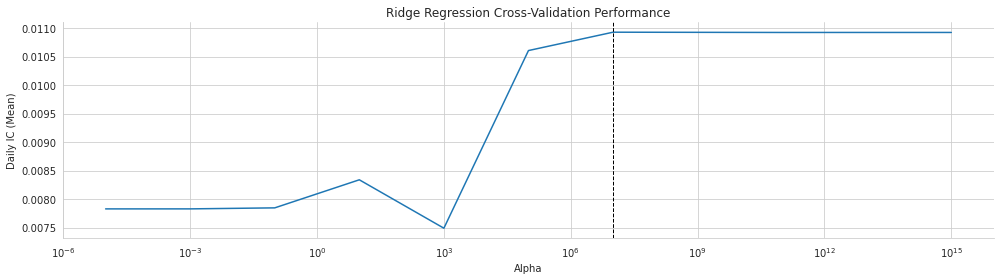

In [39]:
ax = pd.Series(ic_by_day_ridge).plot(figsize=(14, 4),
                                  logx=True, 
                                  title='Ridge Regression Cross-Validation Performance')
ax.axvline(best_alpha_ridge, c='k', ls='--', lw=1)
ax.set_ylabel('Daily IC (Mean)')
ax.set_xlabel('Alpha')
sns.despine()
plt.tight_layout();

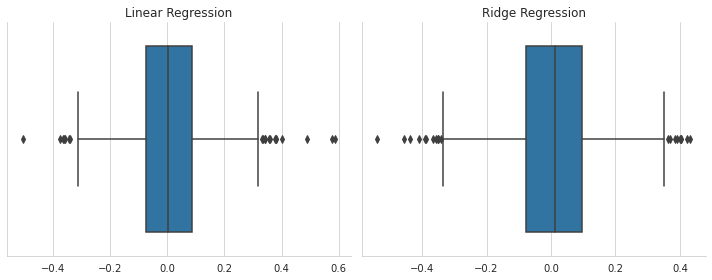

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

sns.boxplot(daily_ic_lr, ax=axes[0], orient='v')
axes[0].set_title('Linear Regression')

ridge_daily_ic = ridge_preds.groupby(level='date').apply(lambda x: spearmanr(x[best_alpha_ridge], x.y_test)[0])
sns.boxplot(ridge_daily_ic, ax=axes[1], orient='v')
axes[0].set_title('Linear Regression')
axes[1].set_title('Ridge Regression')
sns.despine()
fig.tight_layout();

In [43]:
ridge_preds[best_alpha_ridge].to_hdf('predictions.h5', 'ridge_regression')

### Lasso Regression

In [44]:
lasso_alphas = np.logspace(-15, -5, 11)

In [ ]:
lasso_preds = []
scaler = MinMaxScaler()
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'\nFold {i}')
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_train = scaler.fit_transform(X_train)
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_test = scaler.transform(X_test)    
    cv_predictions = []
    for alpha in lasso_alphas:
        print(f'{alpha:.0e}', end=' ', flush=True)
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    lasso_preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))
lasso_preds = pd.concat(lasso_preds)


Fold 0
1e-15 1e-14 1e-13 1e-12 